This notebook is meant to provide a quick demonstration of how a notebook could be used to explore development of new derived acoustic variables.

We will walk through the calculation of the speed of sound using functions from the Ocean Navgiator. We will use data from a sample ocean model file.

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import seawater
import xarray as xr
import scipy.signal as sp

%matplotlib inline

In [113]:
%ls

Ocean-Data-Map-Project/  ocn-nav/


# Load sample model data
This data is from RIOPS polar stereographic 3D output on October 1, 2019 at 00:00.

In [116]:
d = xr.open_dataset('ocn-nav/data/2019100100_000_3D_ps5km60N.nc')
d

<xarray.Dataset>
Dimensions:              (depth: 75, time: 1, xc: 1770, yc: 1610)
Coordinates:
  * xc                   (xc) float32 0.0 5000.0 10000.0 ... 8840000.0 8845000.0
  * yc                   (yc) float32 0.0 5000.0 10000.0 ... 8040000.0 8045000.0
    latitude             (yc, xc) float32 ...
    longitude            (yc, xc) float32 ...
  * depth                (depth) float32 0.50753 1.55757 ... 5698.06 5902.06
  * time                 (time) datetime64[ns] 2019-10-01
Data variables:
    polar_stereographic  |S1 ...
    votemper             (time, depth, yc, xc) float32 ...
    vosaline             (time, depth, yc, xc) float32 ...
    vozocrtx             (time, depth, yc, xc) float32 ...
    vomecrty             (time, depth, yc, xc) float32 ...
Attributes:
    Conventions:      CF-1.6
    title:            Time-averaged sea ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Oce

In [17]:
d.votemper

<xarray.DataArray 'votemper' (time: 1, depth: 75, yc: 1610, xc: 1770)>
[213727500 values with dtype=float32]
Coordinates:
  * xc         (xc) float32 0.0 5000.0 10000.0 ... 8835000.0 8840000.0 8845000.0
  * yc         (yc) float32 0.0 5000.0 10000.0 ... 8035000.0 8040000.0 8045000.0
    latitude   (yc, xc) float32 ...
    longitude  (yc, xc) float32 ...
  * depth      (depth) float32 0.50753 1.55757 2.66934 ... 5698.06 5902.06
  * time       (time) datetime64[ns] 2019-10-01
Attributes:
    units:          Kelvin
    valid_min:      173.0
    valid_max:      373.0
    long_name:      Sea water potential temperature
    short_name:     votemper
    standard_name:  sea_water_potential_temperature
    cell_methods:   time: point
    grid_mapping:   polar_stereographic
    nomvar:         TM
    stdscale:       1.0
    stdoffset:      0.0

## Extract relevant data arrays
For speed of sound, the relevant arrays are depth, temperature, salinity and latitude. 

In [23]:
depth = d.depth.values
temp = d.votemper.values
sal = d.vosaline.values
lat = d.latitude.values
temp.shape

(1, 75, 1610, 1770)

In [22]:
temp.shape
test_temp = temp[0,0,...]
test_temp.shape

(1610, 1770)

## Quick plot of temperature to become familiar with the data
This plot gives an impression of how the surface temperature varies on a map.

WARNING: The plot does not use a proper map projection so the map is not to scale!

Note: the x-axis is the x-index of the data and the y-axis is the y-index of the data. So we know Newfounaldland is around x=1450, y=400.

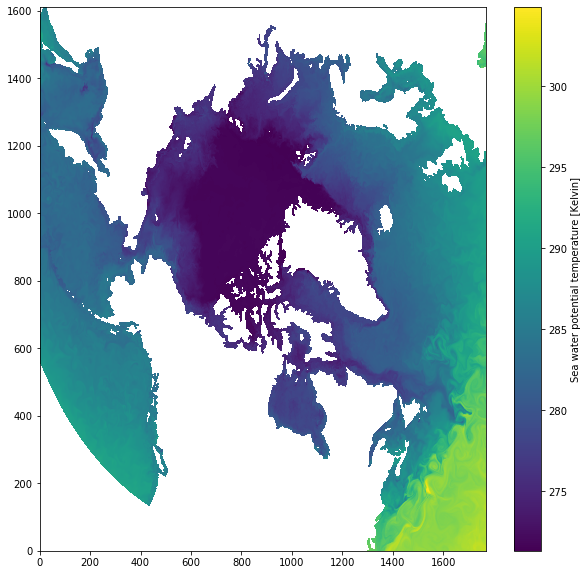

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
mesh = ax.pcolormesh(temp[0,0,...])
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('{} [{}]'.format(d.votemper.attrs['long_name'],
                                d.votemper.attrs['units']))

# Calculating the Speed of Sound
Now we will use functions from the Ocean Navigator to calculate the speed of sound.

## Functions from the Navigator

These functions below are from Ocean-Data-Map-Project/data/calculated_parser/functions.py

https://github.com/DFO-Ocean-Navigator/Ocean-Data-Map-Project/blob/master/data/calculated_parser/functions.py

PS: Ideally we would be able to import the these functions as a library but there are a lot of complicated dependencies so I think this is a simpler approach. 

In [7]:
def __calc_pressure(depth, latitude):
    pressure = []
    try:
        pressure = [seawater.pres(d, latitude) for d in depth]
    except TypeError:
        pressure = seawater.pres(depth, latitude)

    return np.array(pressure)

In [8]:
def __validate_depth_lat_temp_sal(depth, latitude, temperature, salinity):

    if type(depth) is not np.ndarray:
        depth = np.array(depth)

    if type(latitude) is not np.ndarray:
        latitude = np.array(latitude)

    if type(temperature) is not np.ndarray:
        temperature = np.array(temperature)

    if type(salinity) is not np.ndarray:
        salinity = np.array(salinity)

    return depth, latitude, np.squeeze(temperature), np.squeeze(salinity)

In [9]:
def sspeed(depth, latitude, temperature, salinity):
    """
    Calculates the speed of sound.
    Required Arguments:
    * depth: The depth(s) in meters
    * latitude: The latitude(s) in degrees North
    * temperature: The temperatures(s) in Celsius
    * salinity: The salinity (unitless)
    """

    depth, latitude, temperature, salinity = __validate_depth_lat_temp_sal(
        depth, latitude, temperature, salinity)

    press = __calc_pressure(depth, latitude)

    if salinity.shape != press.shape:
        # pad array shape to match otherwise seawater freaks out
        press = press[..., np.newaxis]

    speed = seawater.svel(salinity, temperature, press)
    return np.squeeze(speed)

## Calculate speed of sound everywhere
We will apply these functions to calculate the speed of sound over the entire dataset.

In [24]:
temp_Celsius = temp - 273.15 # convert temp to celsius
speed = sspeed(depth, lat, temp_Celsius, sal)
temp_Celsius.shape

/home/sourav/.conda/envs/navigator/lib/python3.6/site-packages/seawater/eos80.py:928: RuntimeWarning: invalid value encountered in sqrt
  return Cw + A * s + B * s * s ** 0.5 + D * s ** 2


array([[[[       nan,        nan,        nan, ..., 28.449554 ,
          28.449554 , 28.449554 ],
         [       nan,        nan,        nan, ..., 28.46518  ,
          28.46518  , 28.46518  ],
         [       nan,        nan,        nan, ..., 28.488617 ,
          28.488617 , 28.480804 ],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ..., 28.449463 ,
          28.449463 , 28.449463 ],
         [       nan,        nan,        nan, ..., 28.465088 ,
          28.465088 , 28.465088 ],
         [       nan,        nan,        nan, ..., 28.488525 ,
          28.488525 , 28.480713 ],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,    

In [25]:
temp_Celsius.shape

(1, 75, 1610, 1770)

Plot a map of the sound speed at the surface

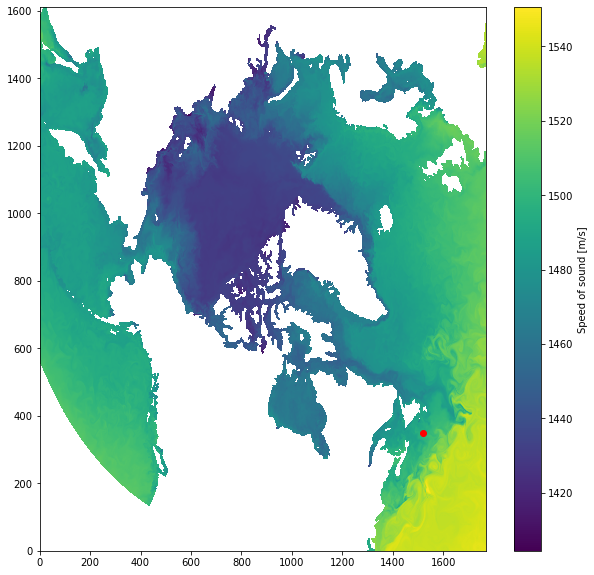

In [92]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
mesh = ax.pcolormesh(speed[0])
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Speed of sound [m/s]')
xc, yc = 1520, 350
ax.plot(xc, yc,'ro')

Plot a speed of sound profile at the red dot

Text(0.5, 0, 'Speed of sound [m/s]')

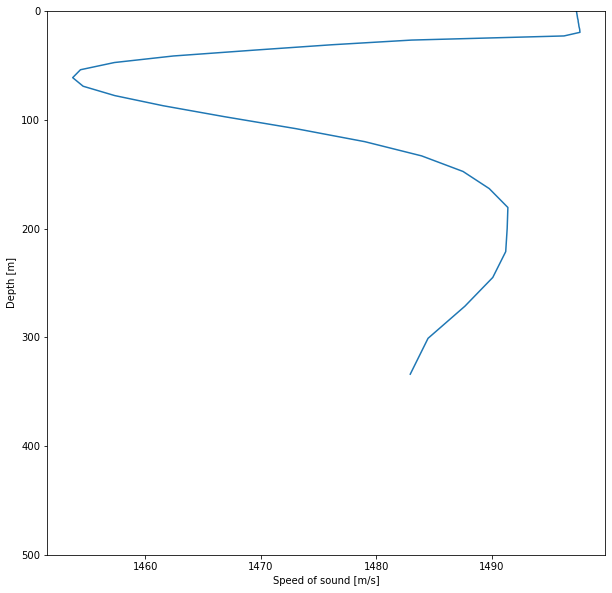

In [42]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(speed[:, yc, xc], depth)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')


### Using *argrelmin* from *scipy.signal* to detect local minima

In [82]:
#selecting a sound speed profile (xc, yc = 1520, 350)
xc, yc = 1520, 350
sspeed_profile = speed[:, yc, xc]
local_minima = sp.argrelmin(sspeed_profile) # get the index of the local minima
local_minima

(array([19]),)

This function *argrelmin* returns an array of index of the given data where the local minima occurs.
A profile containing the sound speed of different depth can be passed to this function, then it will return an array of index where the local minima is present.

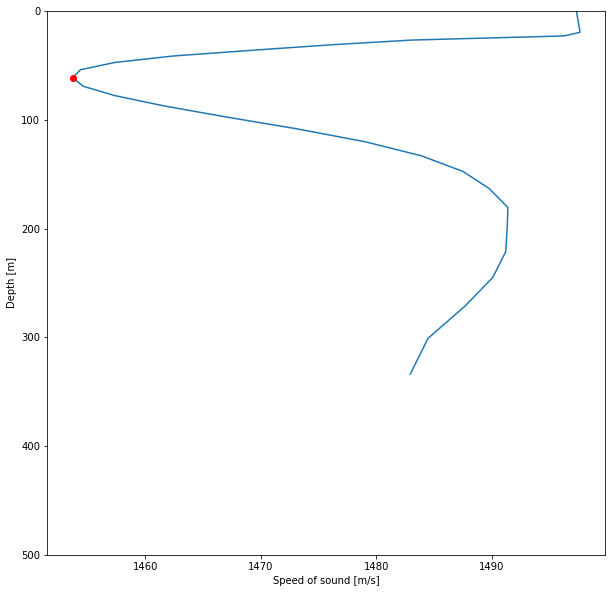

In [83]:
xc, yc = 1520, 350 
sspeed_profile = speed[:, yc, xc]

local_minima = sp.argrelmin(sspeed_profile) # get the index of the local minima
sspeed_profile[local_minima]

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(speed[:, yc, xc], depth)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(sspeed_profile[local_minima],depth[local_minima],'r.',markersize=12)

#### An example with two local minima
I will to choose a profile where there can be two local minimas to test if it is get detected perfectly or not. 

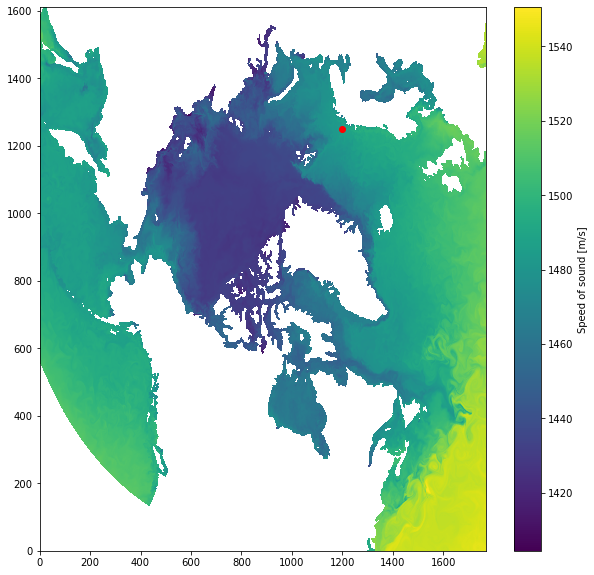

In [131]:
xc, yc = 1200, 1250
fig, ax = plt.subplots(1,1,figsize=(10,10))
mesh = ax.pcolormesh(speed[0])
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Speed of sound [m/s]')
ax.plot(xc, yc,'ro')

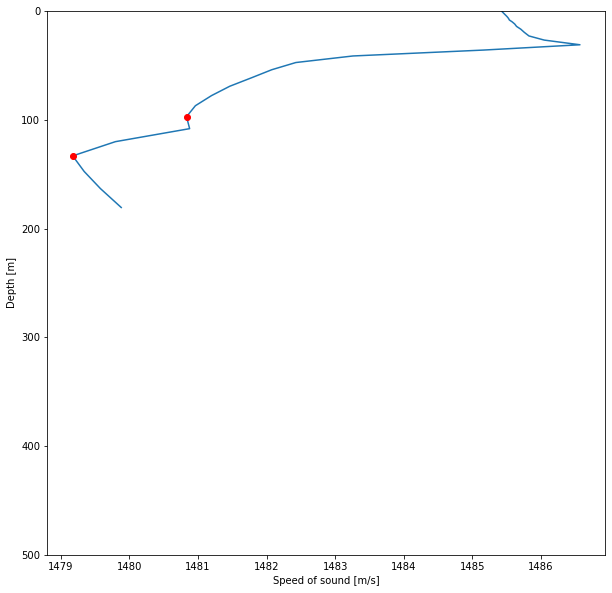

In [137]:
#xc, yc = 150, 1250 
sspeed_profile = speed[:, yc, xc]

local_minima = sp.argrelmin(sspeed_profile) # get the index of the local minima in a tuple 
sspeed_profile[local_minima]

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(speed[:, yc, xc], depth)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(sspeed_profile[local_minima[0]],depth[local_minima[0]],'r.',markersize=12)

In [136]:
type(local_minima[0])

numpy.ndarray

As the *argrelmin* function returns an array of the index where local minima occurs, we can check the size of that returned array to detect, if there exists two local minimas in that particular sound profile before **1000m**, to detect if there is a **sub-surface channel**.


In [140]:
# check if the local minimas are above 1000m 
minima_before_1000 = np.array([local_minima[0][i] if depth[i] <1000])
minima_before_1000
#check if the first maxima and the first minima has a difference >5m/s

SyntaxError: invalid syntax (<ipython-input-140-3904c56763e7>, line 2)

# Next steps

* Can we create a similar notebook to develop algorithms for computing the "Potential for sub-surface sound channel" variable?
* What other functions from the Navigagtor will be needed to support that work?
* What new functions do we need to develop?
* How will we test our algorithms?
  * Will these functions work on profiles loaded from a .csv file? (Hint: we can use a library called pandas to load data from a csv file). 
  
# Some technical considerations
* Here some good resources for on Jupyter notebooks:
  * https://jupyter.org/index.html
  * https://www.dataquest.io/blog/jupyter-notebook-tutorial/
* This notebook has very few libary dependencies/imports (see first cell). When running the notebook, you will need to use an environment that includes those libraries. The Ocean Navigator envivonment should work but you will also need to make sure jupyter in installed in that environment (check with Dwayne). If jupyter is not installed, one option would be to duplicate that environment and then install jupyter.
* You can set up ssh tunnels to run the notebook on your linux computer but interact with it on your windows web-browser. See https://fizzylogic.nl/2017/11/06/edit-jupyter-notebooks-over-ssh/